In [1]:
import multiprocess as mp
import tqdm
import numpy as np
from astropy.table import Table

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# SOM Training and Classification

This project uses the SOM training and classficiation algorthms described in [Sánchez et. al. (2020)](https://arxiv.org/pdf/2004.09542.pdf). 

In [2]:
from NoiseSOM import *
from pipeline_tools import *

## Training

In [3]:
fname = '../data/wide_field_data/BFD/TRAIN_CAT_1E+05.fits'
t = Table.read(fname, format='fits')
list(t.keys())

['id',
 'Mf_per_band',
 'moments',
 'ra',
 'dec',
 'psf_moments',
 'cov_Mf_per_band',
 'covariance',
 'AREA']

In [4]:
fluxes_colname = 'Mf_per_band'
fluxes_err_colname = 'cov_Mf_per_band'

fluxes = t[fluxes_colname].data
fluxes_err = np.sqrt(t[fluxes_err_colname].data)

In [5]:
CAT_TYPE = 'BFD'
out_path = '../outputs/%s/'%CAT_TYPE

somres = 32

In [6]:
if not os.path.exists(out_path+'SOM.pkl'):
    nTrain=fluxes.shape[0]
    hh = hFunc(nTrain,sigma=(30,1))
    metric = AsinhMetric(lnScaleSigma=0.4,lnScaleStep=0.03)
    indices = np.random.choice(fluxes.shape[0],size=nTrain,replace=False)
    som = NoiseSOM(metric,fluxes[indices,:],fluxes_err[indices,:], \
                                learning=hh, \
                                shape=(somres,somres), \
                                wrap=False,logF=True, \
                                initialize='sample', \
                                minError=0.02)

    som.train()
    som.save(path=out_path)
else:
    print("loading SOM from %sSOM.pkl"%out_path)
    som = load_SOM(out_path+'SOM.pkl')

loading SOM from ../outputs/BFD/SOM.pkl


## Classification 

Now that the SOM is trained, we will use the validation catalog to ensure that the SOM algorithm worked correctly.

In [7]:
fname = '../data/wide_field_data/BFD/VALIDATION_CAT_1E+05.fits'
t = Table.read(fname, format='fits')

### Assigning Galaxies to Cells

Now we're going to run the Noise_SOM `classify` function to classify the random subset of the catalog. This can be done in parallel, so let's define a function that can be run in multiprocessing:

In [8]:
num_inds = 1000
inds = np.array_split(np.arange(len(t[fluxes_colname])),num_inds)
def assign_som(index):
    cells_test, _ = som.classify(t[fluxes_colname][inds[index]], 
                                     t[fluxes_err_colname][inds[index]])
    
    return cells_test

In [9]:
# Now running the multiprocessing pool (this can take a few minutes)
def run_pools():
    
    filename = "%s/assignments.pkl"%out_path
    if not os.path.exists(filename):
        print("Assigning Galaxies...")
        with mp.Pool(4) as p: 
            args = [(i,) for i in range(num_inds)]
            results = list(tqdm.tqdm(p.imap(assign_som, range(num_inds)), total=num_inds))
        
        assignments = []
        for res in results:
            assignments = np.append(assignments,res)
            
        with open(filename, 'wb') as f:
            pickle.dump(assignments, f)
            f.close()
    else:
        print("Loading Galaxy Assignments...")
        with open(filename, 'rb') as f:
            assignments = pickle.load(f)
        
    print("Done")
    return assignments
    
    
if __name__ == '__main__':
    assignments = run_pools()
    
    t['Wide Cell Assignment'] = assignments

Assigning Galaxies...


100%|███████████████████████████████████████| 1000/1000 [01:59<00:00,  8.39it/s]


Done


### Calculating aggregate properties of the galaxies in each cell

Here we use the [astropy aggregate function](https://docs.astropy.org/en/stable/api/astropy.table.TableGroups.html#astropy.table.TableGroups.aggregate) to group the table based on the wide cell assignments and perform aggregate functions on them, in this case average and standard deviation. 

In [10]:
mags = flux_to_mag(t[fluxes_colname].data)
bands = ['g', 'r', 'i', 'z']
for i,b in enumerate(bands):
    t['%s_mag'%b] = mags[:,i]
    t['SN_%s'%b] = (t['Mf_per_band']/np.sqrt(t['cov_Mf_per_band']))[:,i]
    
colors = ['g-r', 'r-i', 'i-z']
for i, c in enumerate(colors):
    t[c] = mags[:,i]-mags[:,i+1]
    


def masked_nanmean(col):
    return np.nanmean(col[(col<np.inf)&(col>-np.inf)])

def masked_nanstd(col):
    return np.nanstd(col[(col<np.inf)&(col>-np.inf)])
    
grouped_by_wc = t.group_by('Wide Cell Assignment')
averages = grouped_by_wc.groups.aggregate(masked_nanmean)
stddev = grouped_by_wc.groups.aggregate(masked_nanstd)

/Users/danecross/Desktop/SOMs/SOM-photoz-BFD/src/pipeline_tools.py:6: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(f) + const
/Users/danecross/Desktop/SOMs/SOM-photoz-BFD/src/pipeline_tools.py:6: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f) + const
/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_13760/1696390580.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(col[(col<np.inf)&(col>-np.inf)])
/Users/danecross/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Plots!

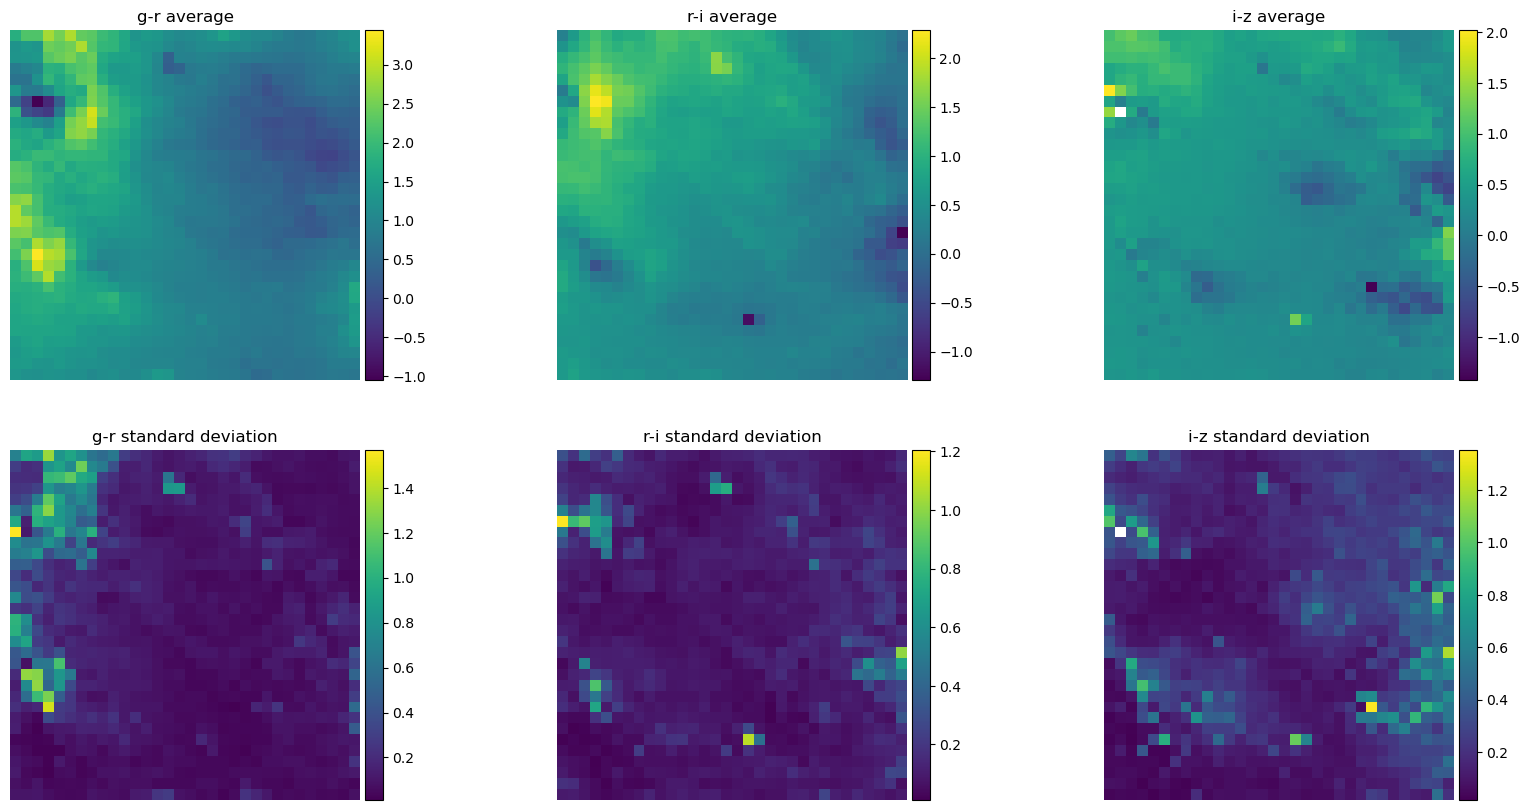

In [11]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

for a,c in zip(axs.T,colors):
    
    im0=a[0].imshow(averages[c].reshape(somres,somres), ) ; a[0].set_title(label=c+' average')
    im1=a[1].imshow(stddev[c].reshape(somres,somres)) ; a[1].set_title(label=c+' standard deviation')
    
    a[0].axis('off')
    a[1].axis('off')
    
    divider = make_axes_locatable(a[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')
    
    divider = make_axes_locatable(a[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
plt.show()

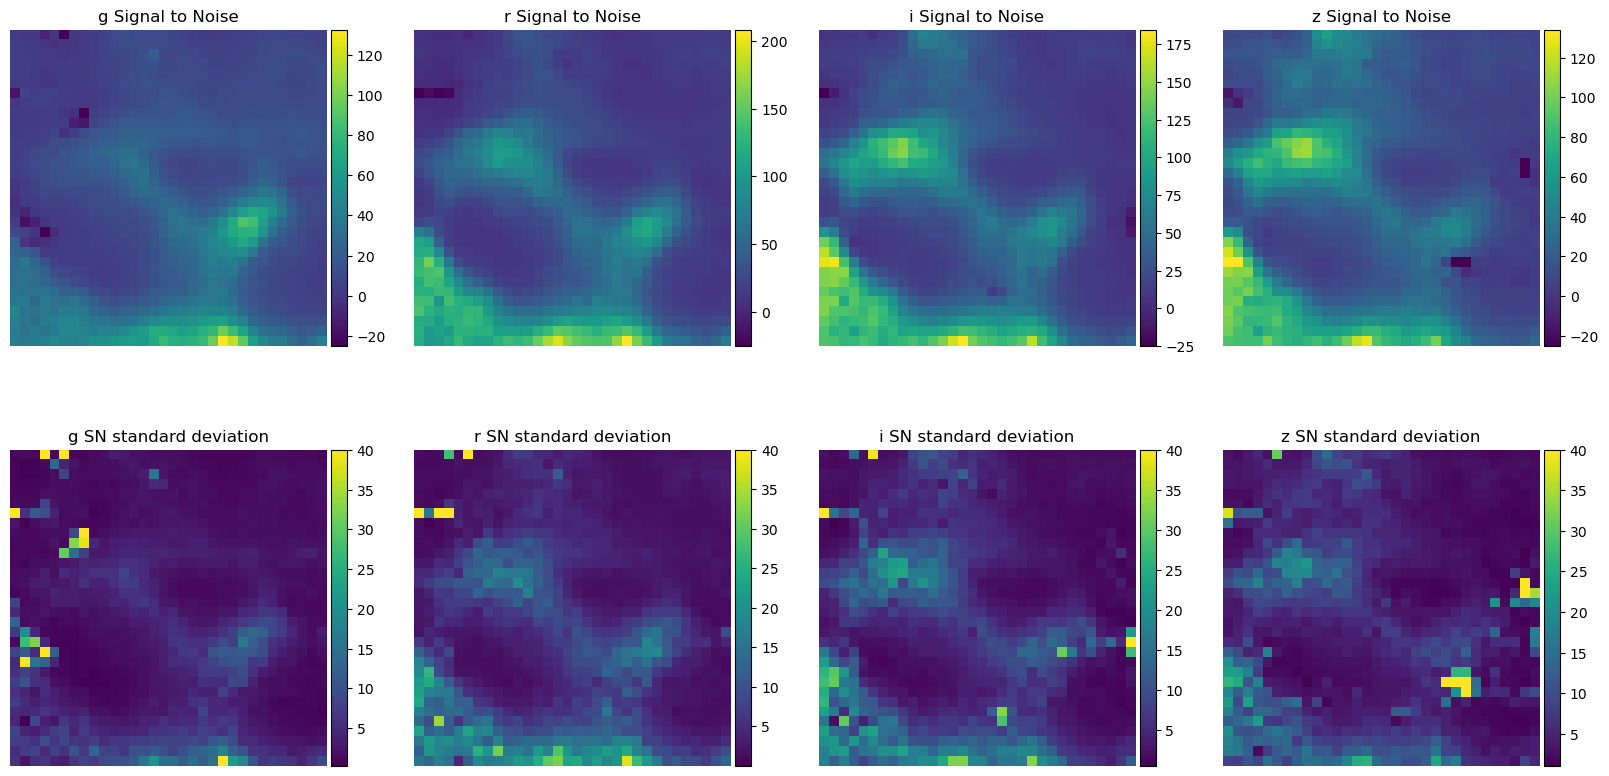

In [12]:
fig, axs = plt.subplots(2,4, figsize=(20,10))

for i,a,c in zip(range(4), axs.T,list('griz')):
    
    im0=a[0].imshow(averages['SN_'+c].reshape(somres,somres), vmin=-25) 
    im1=a[1].imshow(stddev['SN_'+c].reshape(somres,somres), vmax=40) 
    
    a[0].set_title(label=c+' Signal to Noise')
    a[1].set_title(label=c+' SN standard deviation')
    
    a[0].axis('off')
    a[1].axis('off')
    
    divider = make_axes_locatable(a[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')
    
    divider = make_axes_locatable(a[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
plt.show()